## Imports and config; setting the random seed

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

pd.pandas.set_option('display.max_columns', None)
RANDOM_STATE = 0

## Train parameters to pickle

Our feature engineering techniques will learn:

* mean
* mode
* exponents for the yeo-johnson
* category frequency
* and category to number mappings

from the **train set.**

In [54]:
data = pd.read_csv('data/house_prices/train.csv') # reserve kaggle test for final evaluation
print(data.shape)

(1460, 81)


In [55]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Train-test split

In [56]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_valid, y_train, y_valid = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), 
    data['SalePrice'], 
    test_size=0.1, 
    random_state=RANDOM_STATE,
)

X_train.shape, X_valid.shape

((1314, 79), (146, 79))

## Feature engineering: features

In the following cells, we will engineer the variables of the **House Price Dataset** so that we tackle:

- Missing values
- Temporal variables
- Non-Gaussian distributed variables
- Categorical variables: remove rare labels
- Categorical variables: convert strings to numbers
- Put the variables in a similar scale


## Feature engineering: target


In [57]:
y_train = np.log(y_train)
y_valid = np.log(y_valid)

## Missing values

1. Replace nans with string "missing" in vars with lots of missing data.
2. Replace nans with most frequent category in vars that contain fewer observations without values. 

In [58]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['MSSubClass']

X_train[cat_vars] = X_train[cat_vars].astype('O')
X_valid[cat_vars] = X_valid[cat_vars].astype('O')

In [59]:
len(cat_vars)

44

In [60]:
cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
] # we do all feature engineering based on train set.

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

In [61]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1]

# if missing is rare, we don't want to add rare labels, 
# hence we impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1]


In [62]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [63]:
with_frequent_category

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [64]:
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')
X_valid[with_string_missing] = X_valid[with_string_missing].fillna('Missing')

In [65]:
for var in with_frequent_category:
    
    # there can be more than 1 mode in a variable; take first
    mode = X_train[var].mode().tolist()[0]
    
    print(var, mode)
    
    # replace nans with train mode
    X_train[var].fillna(mode, inplace=True)
    X_valid[var].fillna(mode, inplace=True)


MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [66]:
X_train[cat_vars_with_na].isnull().sum().sum() # count all nans in any column

0

In [67]:
X_valid[cat_vars].isnull().sum().sum()

0

## Numerical variables

1. create indicator variable `{var}_na` for every numerical variable `var`.
2. fill na with mean. 

In [68]:
num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'SalePrice'
]

# number of numerical variables
len(num_vars)

35

In [69]:
# make a list with the numerical variables that contain missing values
num_vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[num_vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

**Remark**: mean imputation with `GarageYrBlt` is weird. Perhaps better is DecisionTree imputation. 

In [70]:
# replace missing values as we described above
for var in num_vars_with_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()
    
    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[f'{var}_na'] = np.where(X_train[var].isnull(), 1, 0)
    X_valid[f'{var}_na'] = np.where(X_valid[var].isnull(), 1, 0)

    # replace missing values by the train mean
    X_train[var].fillna(mean_val, inplace=True)
    X_valid[var].fillna(mean_val, inplace=True)

LotFrontage 69.87974098057354
MasVnrArea 103.7974006116208
GarageYrBlt 1978.2959677419356


In [71]:
X_train[num_vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [72]:
X_valid[num_vars].isnull().sum().sum()

0

## Temporal variables

We learned in the previous notebook, that there are 4 variables that refer to the years in which the house or the garage were built or remodeled.

We will capture the time elapsed between those variables and the year in which the house was sold:

In [73]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [74]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_valid = elapsed_years(X_valid, var)

In [75]:
# now we drop YrSold
X_train.drop(['YrSold'], axis=1, inplace=True)
X_valid.drop(['YrSold'], axis=1, inplace=True)

## Numerical variable transformation

### Log-transform

In [76]:
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']:
    X_train[var] = np.log(X_train[var])
    X_valid[var] = np.log(X_valid[var])

In [77]:
[var for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea'] if X_valid[var].isnull().sum() > 0]

[]

In [78]:
[var for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea'] if X_train[var].isnull().sum() > 0]

[]

### Yeo-Johnson transform 

Recall only improvement is in `LotArea`.

In [79]:
X_train['LotArea'], param = stats.yeojohnson(X_train['LotArea'])
X_valid['LotArea'] = stats.yeojohnson(X_valid['LotArea'], lmbda=param)

In [80]:
print(param)

1.3691476824548794


In [81]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [82]:
[var for var in X_valid.columns if X_valid[var].isnull().sum() > 0]

[]

## Binarize skewed variables

Recall skewed variables have different mean `SalePrice`. 

In [83]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

In [84]:
for var in skewed: 
    # recall these variables are almost always zero
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_valid[var] = np.where(X_valid[var]==0, 0, 1)

## Encode categorical variables

In [85]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_valid[var] = X_valid[var].map(qual_mappings)

In [86]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_valid[var] = X_valid[var].map(exposure_mappings)

In [87]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_valid[var] = X_valid[var].map(finish_mappings)

In [88]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_valid[var] = X_valid[var].map(garage_mappings)

In [89]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_valid[var] = X_valid[var].map(fence_mappings)

In [90]:
# check for nans
X_train.isnull().sum().sum() + X_valid.isnull().sum().sum()

0

## Removing rare labels

In [91]:
# capture the remaining categorical variables (those that we did not re-map)
processed_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

cat_others = [var for var in cat_vars if var not in processed_vars]

len(cat_others)


30

In [92]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [93]:
for var in cat_others:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_valid[var] = np.where(X_valid[var].isin(frequent_ls), X_valid[var], 'Rare')

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Missing', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Con

## Target encoding "other" categorical variables

In [94]:
def replace_categories(train, valid, y_train, var, target):
    
    tmp = pd.concat([X_train, y_train], axis=1)    
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a map of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels)}
    
    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    valid[var] = valid[var].map(ordinal_label)

In [95]:
for var in cat_others:
    replace_categories(X_train, X_valid, y_train, var, 'SalePrice')

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story'

In [96]:
X_train.isnull().sum().sum() + X_valid.isnull().sum().sum()

0

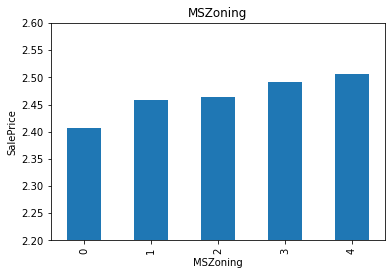

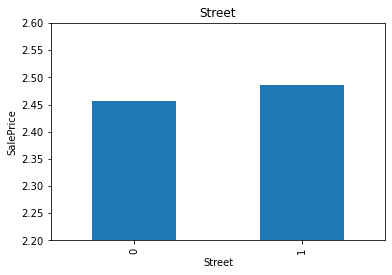

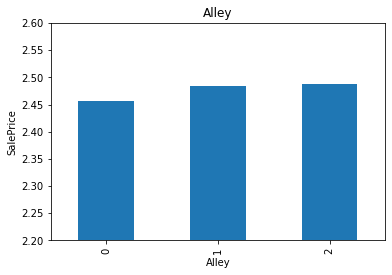

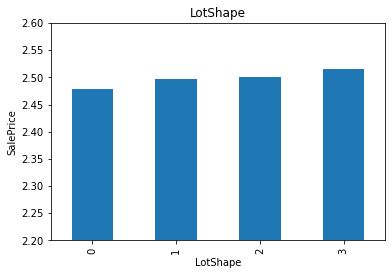

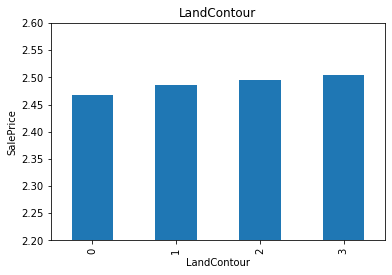

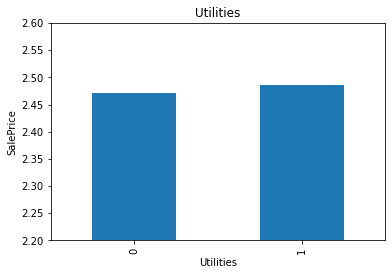

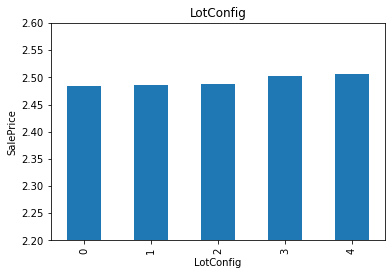

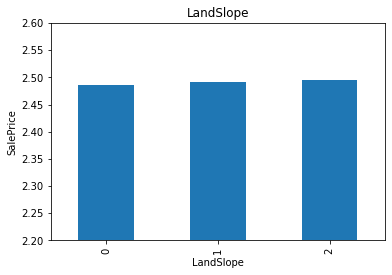

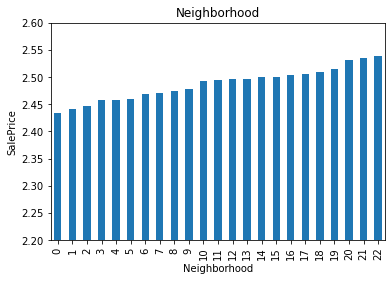

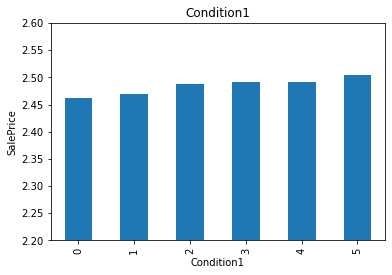

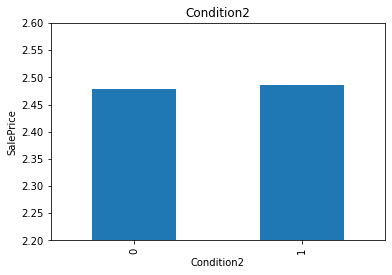

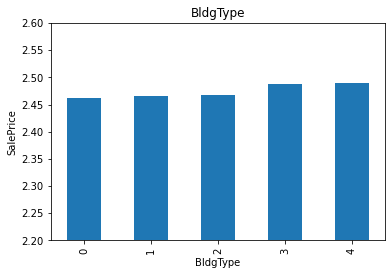

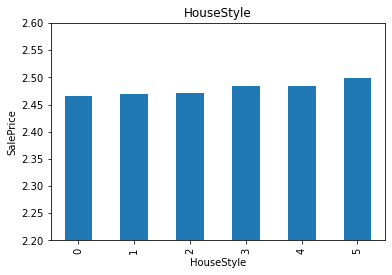

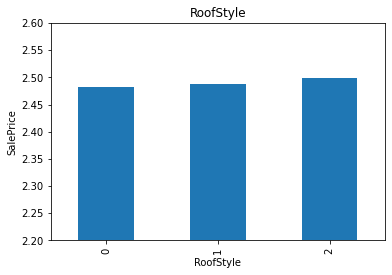

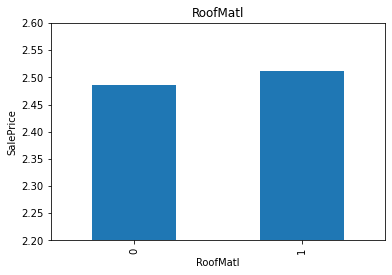

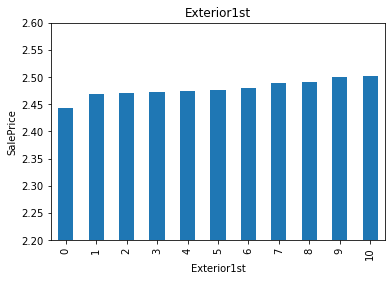

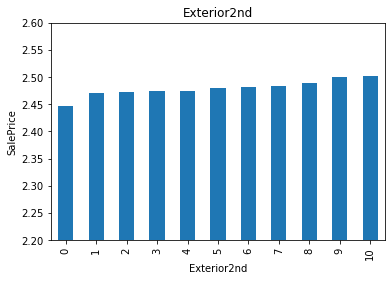

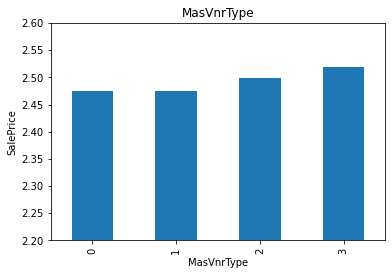

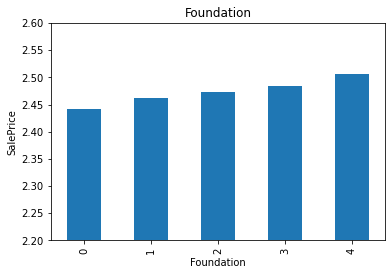

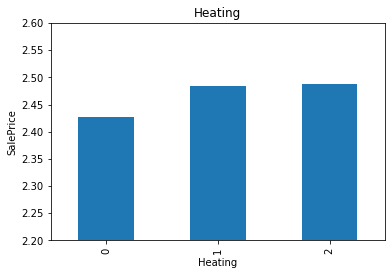

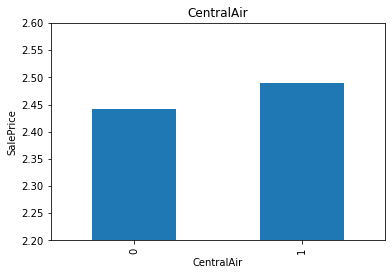

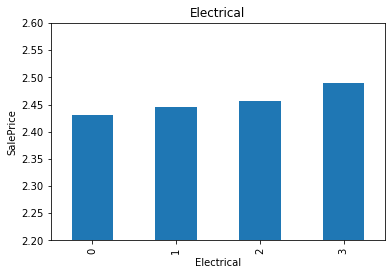

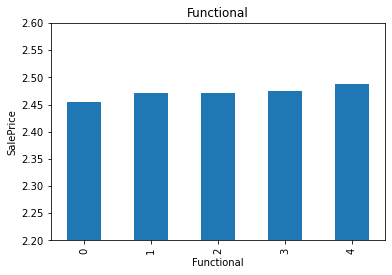

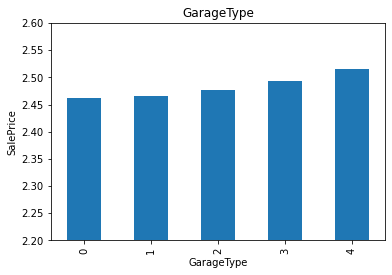

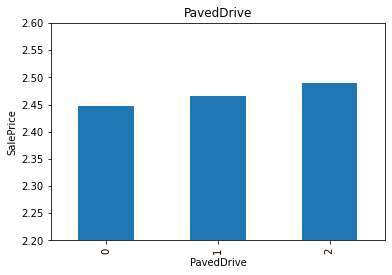

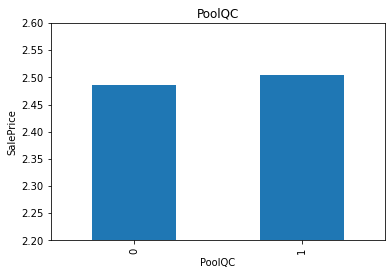

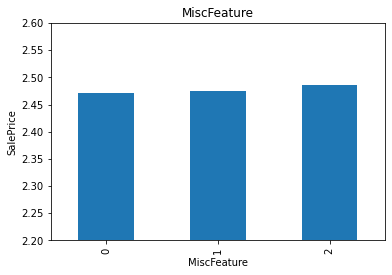

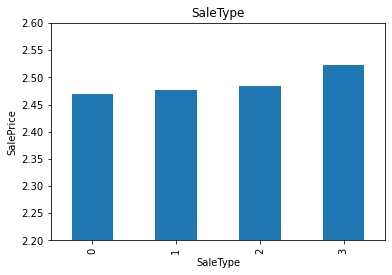

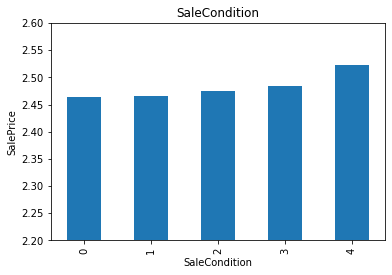

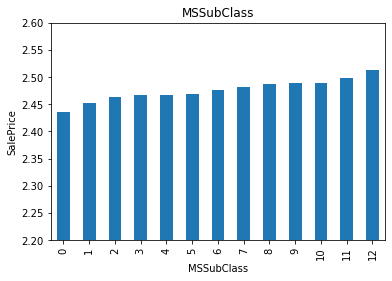

In [97]:
def analyse_vars(train, y_train, var):
    
    # function plots mean house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)


## Feature scaling

In [99]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_valid = pd.DataFrame(
    scaler.transform(X_valid),
    columns=X_train.columns
)

In [100]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.461171,0.355980,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.75,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0
1,0.750000,0.75,0.456066,0.377977,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,0.5,0.5,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.75,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
2,0.916667,0.75,0.394699,0.326692,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,0.5,1.0,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.75,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.090909,0.666667,0.75,0.0,0.0,0.0
3,0.750000,0.75,0.445002,0.471525,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.75,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.636364,0.666667,0.75,1.0,0.0,0.0
4,0.750000,0.75,0.577658,0.381185,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,0.5,0.5,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.75,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0


In [101]:
X_valid.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.445002,0.610643,1.0,1.0,0.333333,0.333333,1.0,1.0,0.0,0.727273,0.4,1.0,0.75,0.6,0.555556,0.250,0.367647,0.540984,1.0,0.0,0.1,0.5,0.333333,0.064873,0.666667,0.5,1.0,0.333333,0.666667,0.0,0.4,0.215982,0.0,0.0,0.379006,0.333061,1.0,0.5,1.0,1.000000,0.764014,0.000000,0.0,0.714182,0.333333,0.0,1.000000,0.0,0.500,0.666667,0.333333,0.583333,0.0,0.666667,0.6,0.75,0.299065,0.5,0.50,0.341326,0.5,0.5,1.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.181818,0.666667,0.00,1.0,1.0,0.0
1,0.416667,0.75,0.490408,0.367769,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.363636,0.0,1.0,0.75,0.2,0.555556,0.750,0.477941,0.934426,0.0,0.0,0.1,0.1,0.333333,0.000000,0.333333,0.5,0.5,0.333333,0.666667,0.0,0.6,0.071403,0.4,1.0,0.110543,0.131915,1.0,0.5,1.0,0.666667,0.398758,0.331197,0.0,0.549294,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.000000,0.250000,1.0,0.666667,0.6,0.75,0.607477,0.0,0.25,0.169252,0.5,0.5,1.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
2,0.416667,0.75,0.445002,0.309991,1.0,1.0,0.333333,0.000000,1.0,0.5,0.0,0.181818,0.4,1.0,0.75,0.2,0.444444,0.375,0.433824,0.983607,0.0,0.0,0.3,0.2,0.000000,0.100625,0.333333,0.5,0.5,0.333333,0.666667,0.0,0.2,0.032778,0.0,0.0,0.243381,0.116039,1.0,0.5,1.0,1.000000,0.406964,0.119658,0.0,0.453307,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.6,0.25,0.551402,0.0,0.25,0.248237,0.5,0.5,1.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,1.0,0.0,0.0
3,1.000000,0.75,0.508690,0.377939,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.772727,0.4,1.0,0.75,1.0,0.666667,0.500,0.227941,0.524590,1.0,0.0,0.7,0.7,0.666667,0.186875,0.333333,0.5,0.5,0.666667,0.666667,0.0,0.6,0.069454,0.0,0.0,0.356712,0.189853,1.0,1.0,1.0,1.000000,0.469855,0.462607,0.0,0.636999,0.000000,0.0,0.666667,0.5,0.500,0.333333,0.333333,0.500000,1.0,0.333333,0.6,0.75,0.289720,1.0,0.50,0.356135,0.5,0.5,1.0,0.336056,0.213894,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.181818,0.666667,0.75,0.0,0.0,0.0
4,0.333333,0.25,0.000000,0.045755,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.090909,0.4,1.0,0.50,1.0,0.555556,0.500,0.286765,0.655738,0.0,0.0,0.6,0.5,0.666667,0.238125,0.333333,0.5,0.5,0.333333,0.666667,0.0,0.0,0.000000,0.0,0.0,0.243846,0.085925,1.0,0.5,1.0,1.000000,0.171149,0.302885,0.0,0.419061,0.000000,0.0,0.333333,0.5,0.375,0.333333,0.333333,0.333333,1.0,0.000000,0.0,0.25,0.364486,0.0,0.25,0.186178,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.181818,0.666667,0.50,0.0,0.0,0.0


In [102]:
# let's now save the train and test sets for the next notebook!
X_train.to_csv('models/xtrain.csv', index=False)
X_valid.to_csv('models/xvalid.csv', index=False)

y_train.to_csv('models/ytrain.csv', index=False)
y_valid.to_csv('models/yvalid.csv', index=False)

In [103]:
# now let's save the scaler
joblib.dump(scaler, 'models/minmax_scaler.joblib')

['models/minmax_scaler.joblib']